In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
np.set_printoptions(threshold=np.inf)
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [0]:
cases = pd.read_csv('time_series_covid19_confirmed_new.csv')
cases = cases.drop(columns = ['Province/State','Lat','Long'])
country_cases = cases.groupby(['Country/Region'],as_index=False).agg('sum')

# plot confirmed case for some country

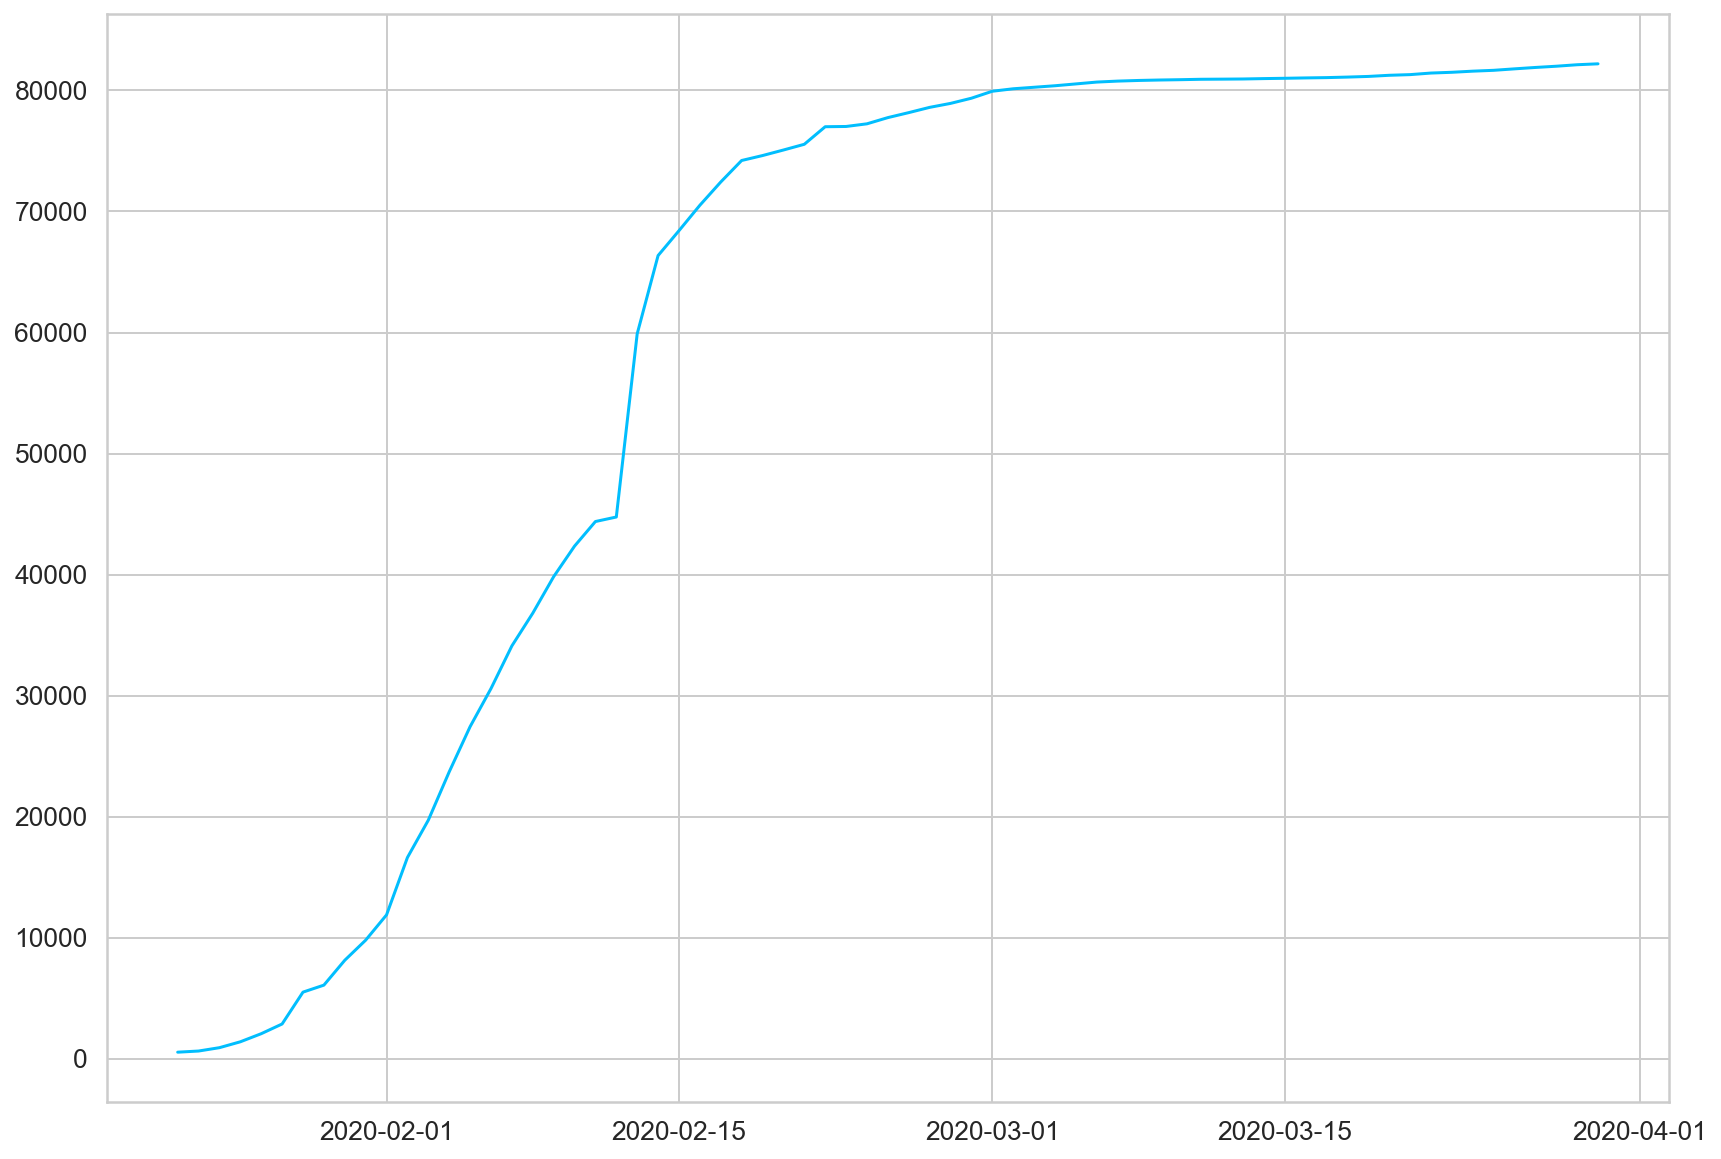

In [0]:
China = country_cases.loc[country_cases['Country/Region'] == 'China'] 
China = China.iloc[0,1:]
China.index = pd.to_datetime(China.index)
plt.plot(China)

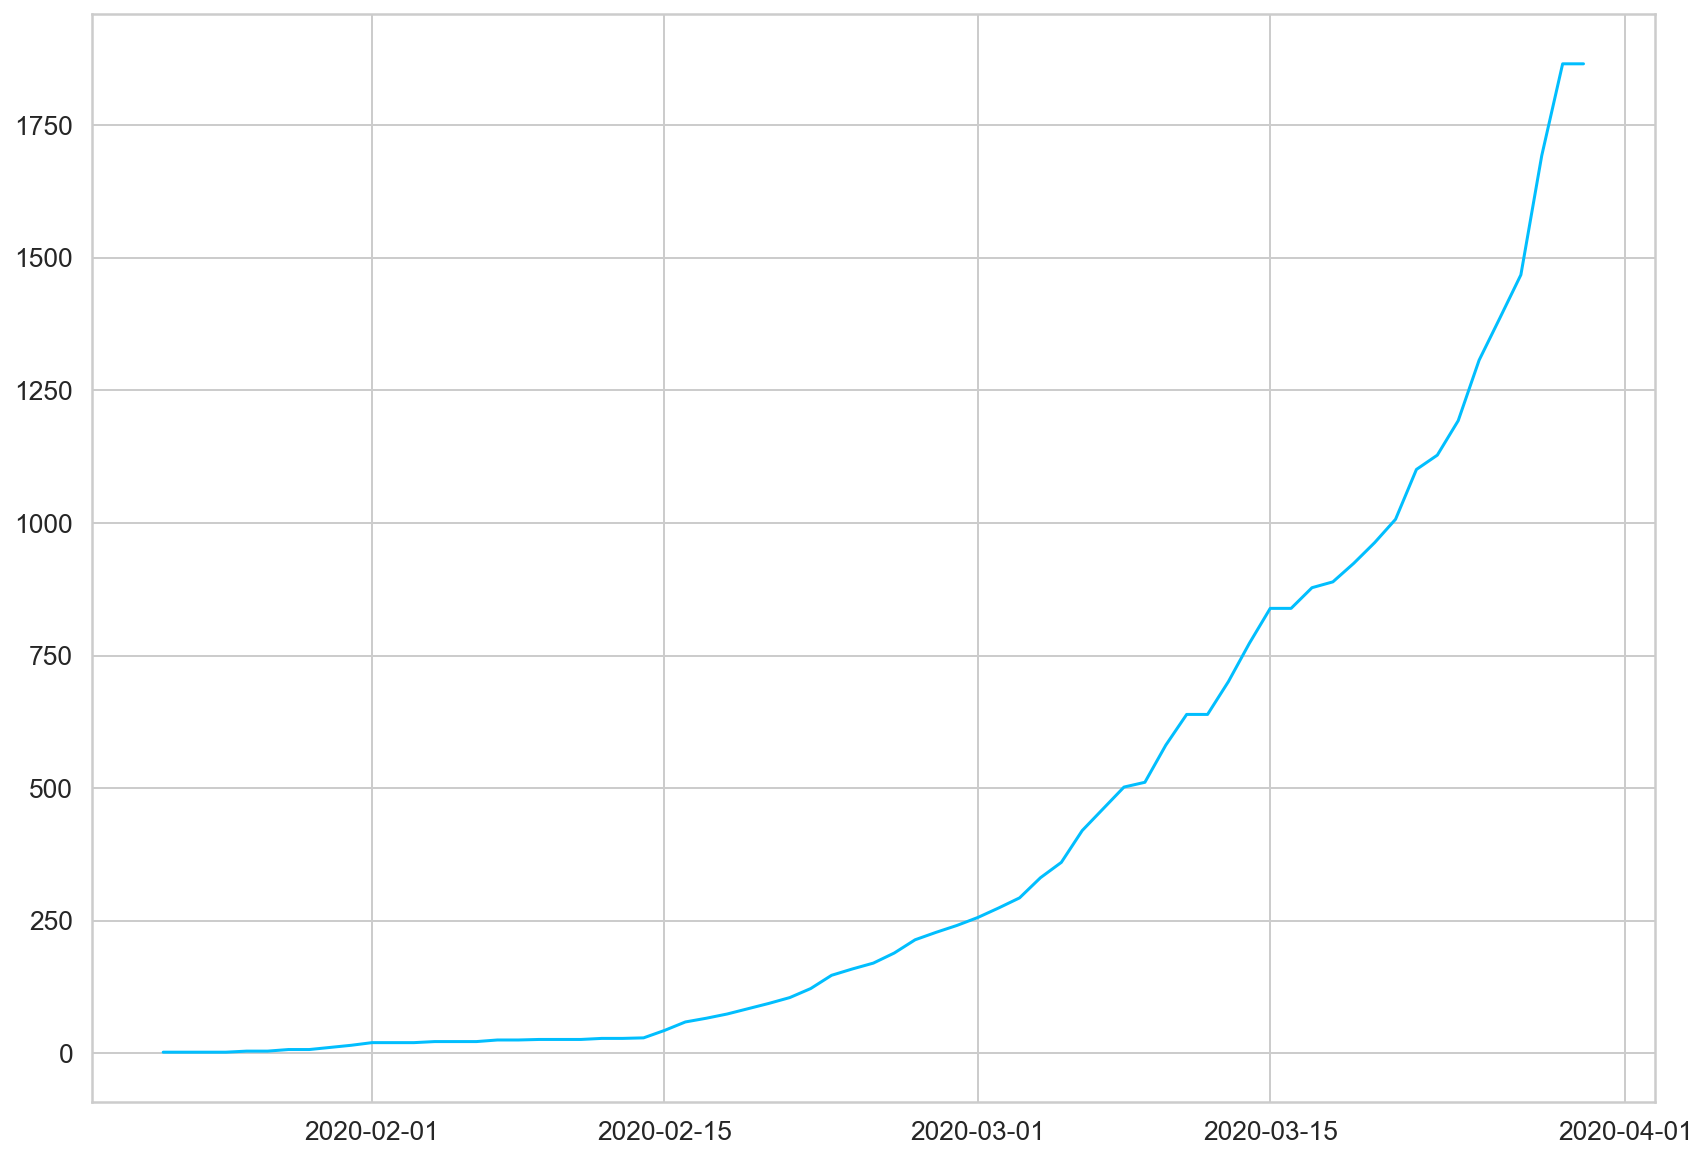

In [0]:
Japan = country_cases.loc[country_cases['Country/Region'] == 'Japan'] 
Japan = Japan.iloc[0,1:]
Japan.index = pd.to_datetime(Japan.index)
plt.plot(Japan)

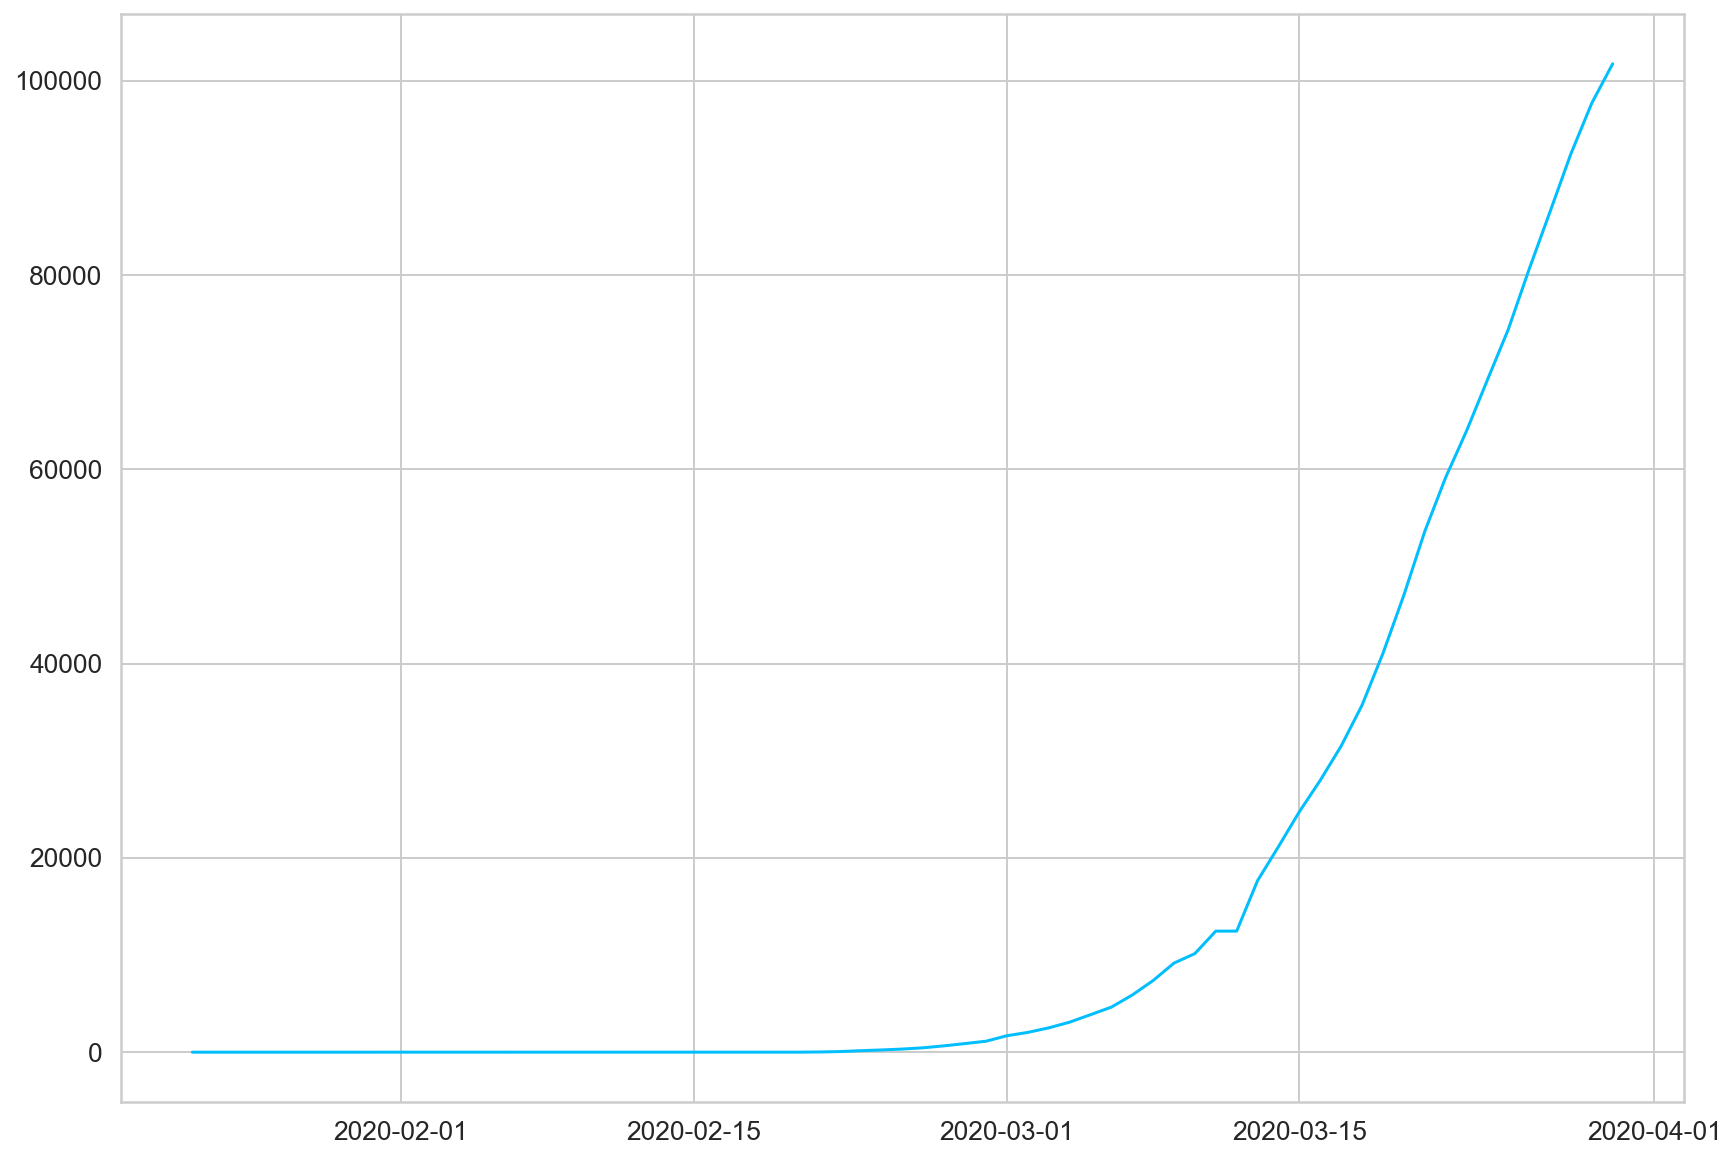

In [0]:
Italy = country_cases.loc[country_cases['Country/Region'] == 'Italy'] 
Italy = Italy.iloc[0,1:]
Italy.index = pd.to_datetime(Italy.index)
plt.plot(Italy)

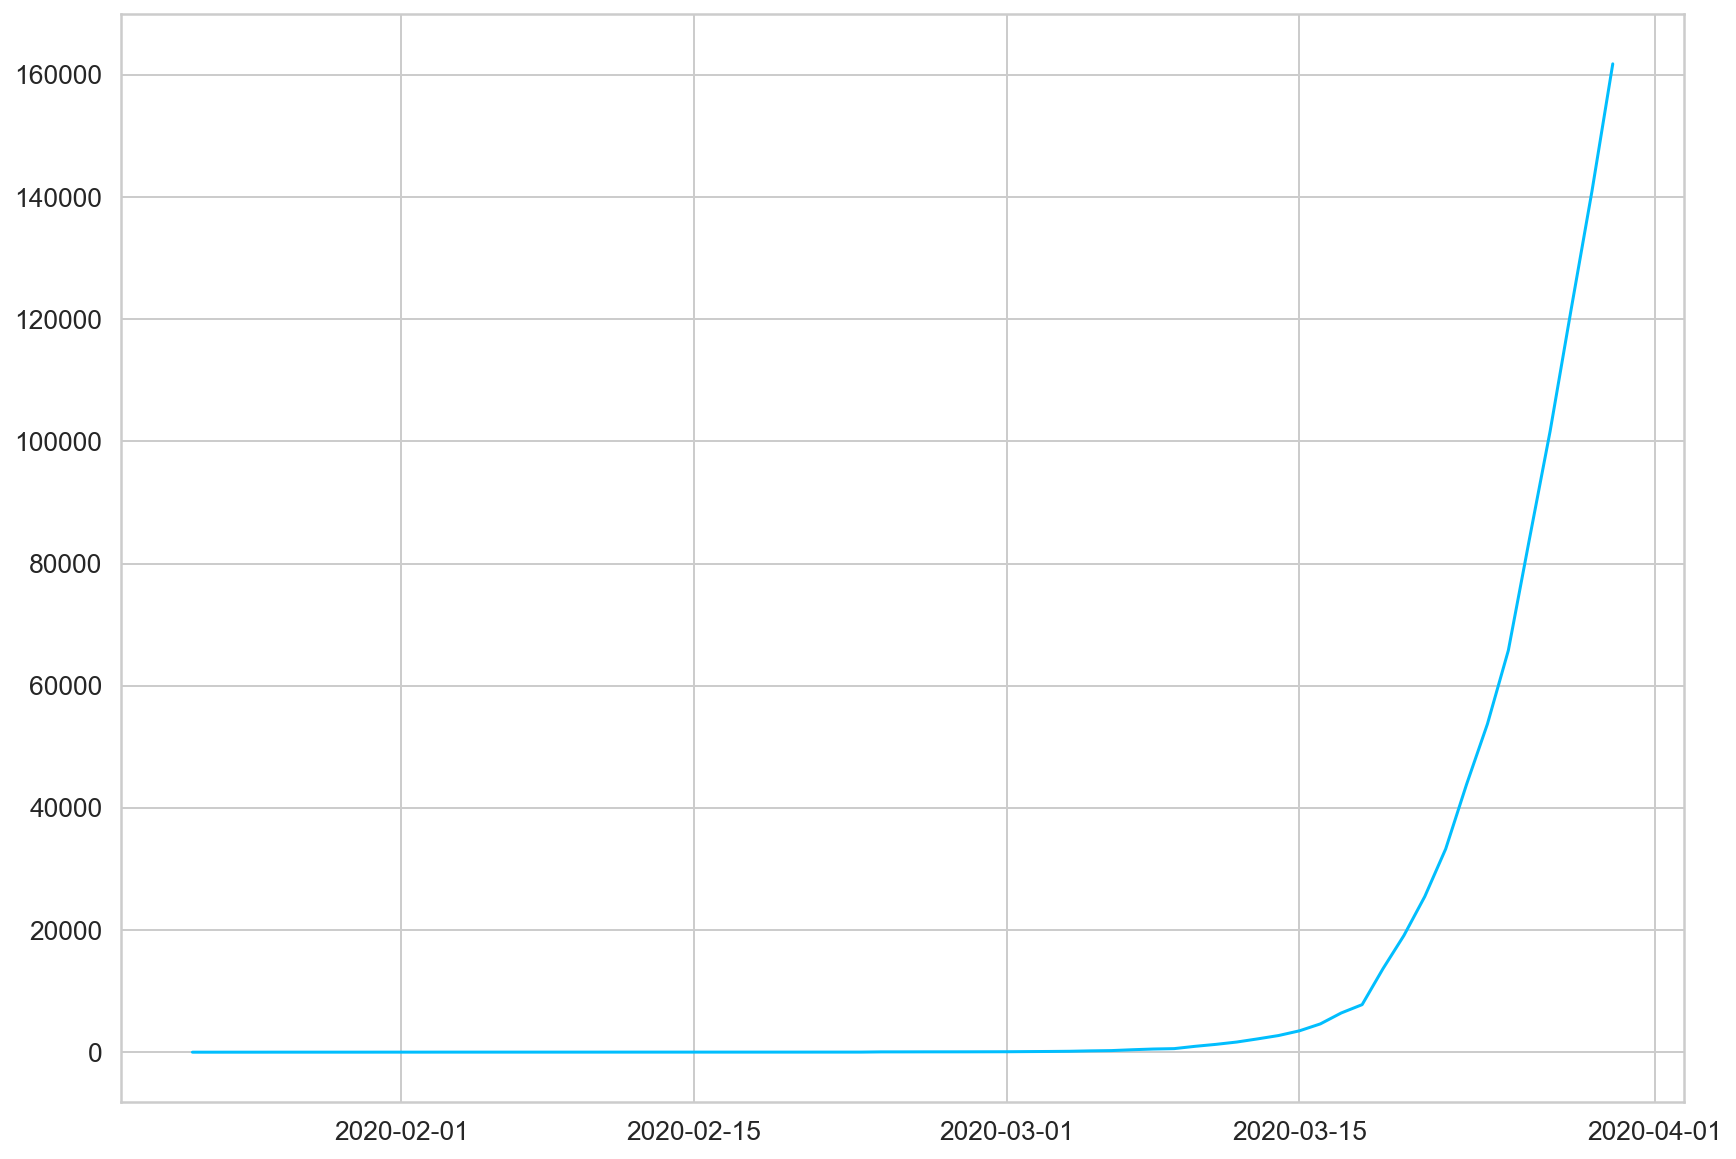

In [0]:
US = country_cases.loc[country_cases['Country/Region'] == 'US'] 
US = US.iloc[0,1:]
US.index = pd.to_datetime(US.index)
plt.plot(US)

# Model for single country

In [0]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [0]:
cases = country_cases.loc[country_cases['Country/Region'] == 'US'] 
cases = cases.drop(columns = ['Country/Region'])
cases = cases.astype('float64')
dataset = cases.to_numpy()[0]

In [0]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset[:, np.newaxis])

In [0]:
test_data_size = 10
train = dataset[:-test_data_size]
test = dataset[-test_data_size:]

In [0]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
single_model = Sequential()
single_model.add(LSTM(4, input_shape=(1, look_back)))
single_model.add(Dense(1))
single_model.compile(loss='mean_squared_error', optimizer='adam')
single_model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
 - 1s - loss: 2.2383e-04
Epoch 2/50
 - 0s - loss: 2.1491e-04
Epoch 3/50
 - 0s - loss: 2.0733e-04
Epoch 4/50
 - 0s - loss: 2.0492e-04
Epoch 5/50
 - 0s - loss: 1.9654e-04
Epoch 6/50
 - 0s - loss: 1.9195e-04
Epoch 7/50
 - 0s - loss: 1.9836e-04
Epoch 8/50
 - 0s - loss: 1.9873e-04
Epoch 9/50
 - 0s - loss: 1.8800e-04
Epoch 10/50
 - 0s - loss: 1.8605e-04
Epoch 11/50
 - 0s - loss: 1.9247e-04
Epoch 12/50
 - 0s - loss: 1.7522e-04
Epoch 13/50
 - 0s - loss: 1.7162e-04
Epoch 14/50
 - 0s - loss: 1.6733e-04
Epoch 15/50
 - 0s - loss: 1.7791e-04
Epoch 16/50
 - 0s - loss: 1.5830e-04
Epoch 17/50
 - 0s - loss: 1.7294e-04
Epoch 18/50
 - 0s - loss: 1.5469e-04
Epoch 19/50
 - 0s - loss: 1.5382e-04
Epoch 20/50
 - 0s - loss: 1.5468e-04
Epoch 21/50
 - 0s - loss: 1.4784e-04
Epoch 22/50
 - 0s - loss: 1.4022e-04
Epoch 23/50
 - 0s - loss: 1.3653e-04
Epoch 24/50
 - 0s - loss: 1.3041e-04
Epoch 25/50
 - 0s - loss: 1.2542e-04
Epoch 26/50
 - 0s - loss: 1.2185e-04
Epoch 27/50
 - 0s - loss: 1.1629e-04
Epoch 28/5

In [0]:
# make predictions
trainPredict = single_model.predict(trainX)
testPredict = single_model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 722.94 RMSE
Test Score: 4406.40 RMSE


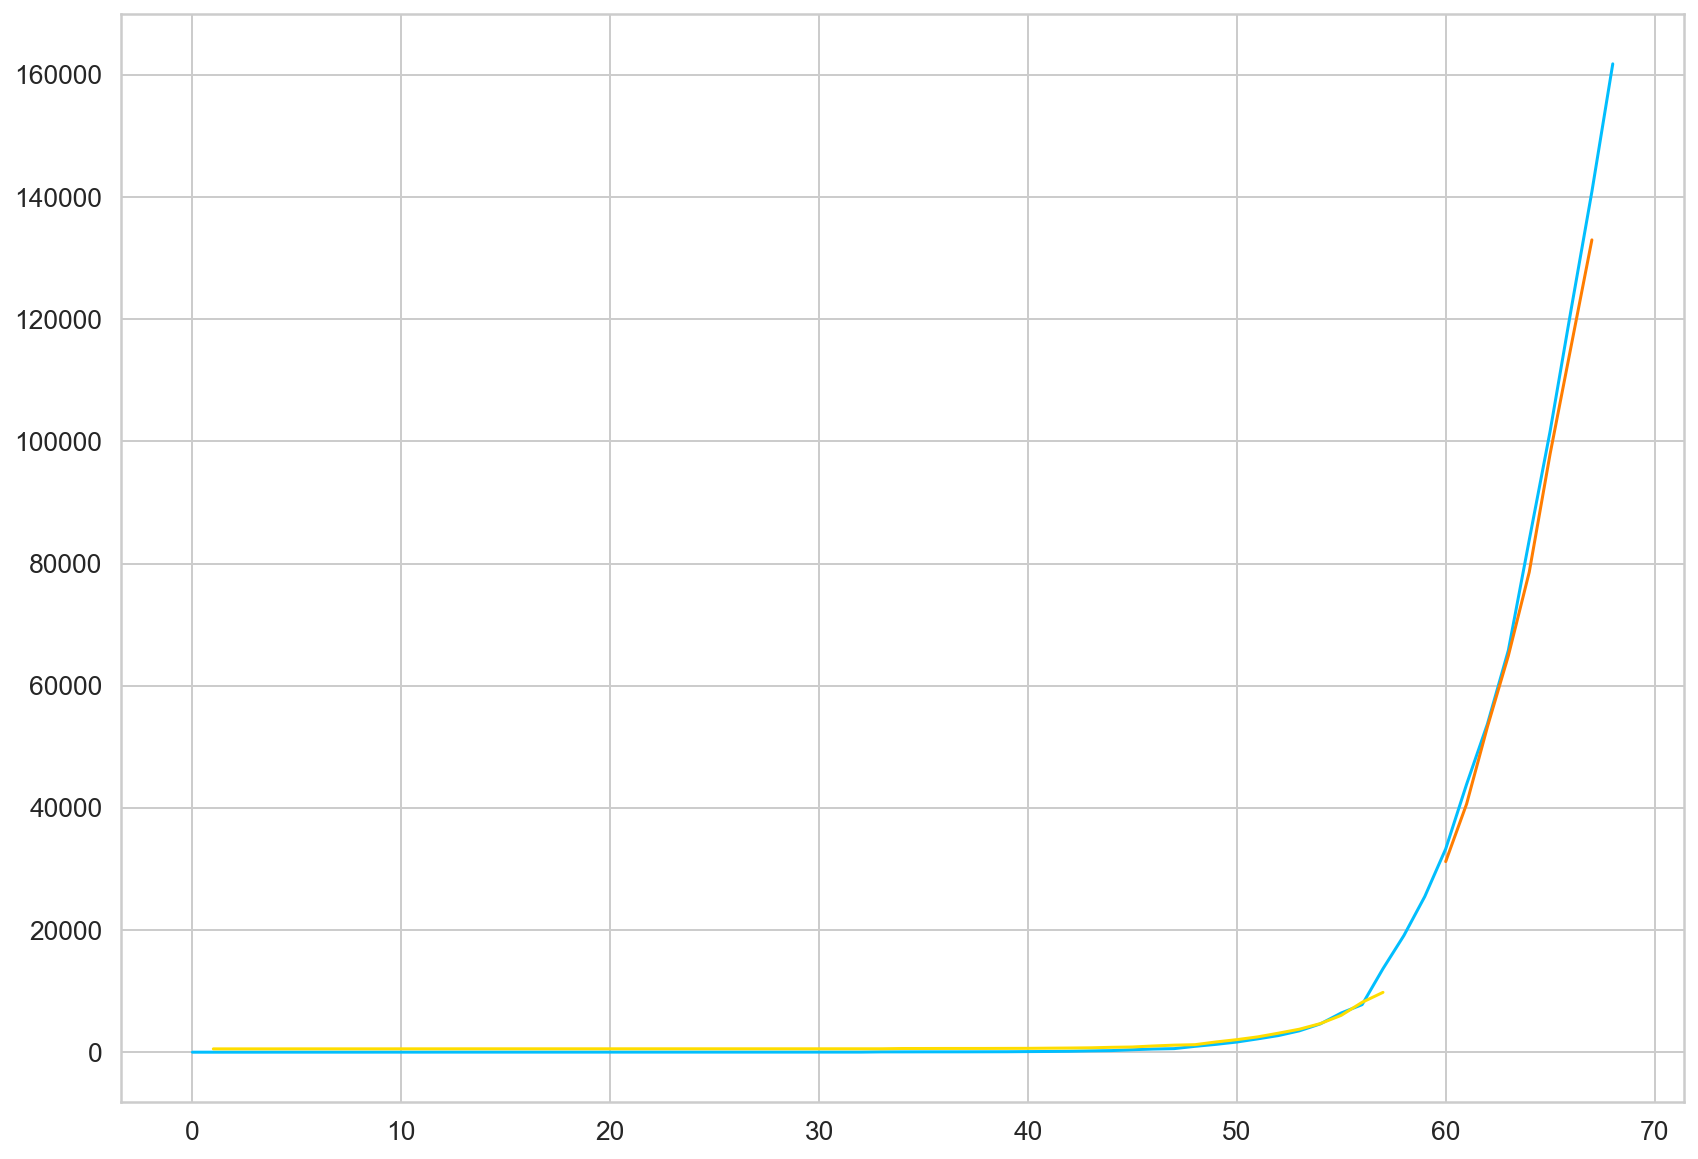

In [0]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# for global

## normalize the data by considering population density

In [0]:
population_density = pd.read_csv('population_density.csv')
population_density['Density'] = population_density['Density'].str.replace(',','').astype(float)
country_cases_density = country_cases.set_index('Country/Region').join(population_density.set_index('Country (or dependent territory)'))

# filter out some countryies that don't have many cases
filter1 = country_cases_density.iloc[:,-2]>1000
country_cases_density.where(filter1, inplace = True)
country_cases_density = country_cases_density.dropna(how = 'all')

# country_cases_density = country_cases_density.drop(['Russia','Czechia'])
country_cases_density.dropna(subset = ["Density"], inplace=True)

# country_cases_density.iloc[0,50]
for i in range(country_cases_density.shape[1]-1):
    country_cases_density.iloc[:,i] = country_cases_density.iloc[:,i]/country_cases_density.iloc[:,-1]

country_density_without_dcolumn = country_cases_density.drop(columns = ['Density'])
# store index of country
countryMap = {}
length = len(country_density_without_dcolumn.index)
for i in range(length):
    countryMap[country_density_without_dcolumn.index[i]] = i

## train model

In [0]:
global_dataset = country_density_without_dcolumn.to_numpy() # convert dataframe to numpy

In [0]:
def create_dataset_global(dataset, look_back=1):
    dataX, dataY = [], []
    for j in range(dataset.shape[0]):
        for i in range(dataset.shape[1]-look_back-1):
            a = dataset[j,i:(i+look_back)]
            if a.any():
                dataX.append(a)
                dataY.append(dataset[j,i + look_back])
    return np.array(dataX), np.array(dataY)

In [0]:
scaler_global = MinMaxScaler(feature_range=(0,1))
global_dataset_scale = scaler_global.fit_transform(global_dataset.flatten()[:, np.newaxis])
global_dataset_scale = np.reshape(global_dataset_scale,(global_dataset.shape[0],global_dataset.shape[1]))

In [0]:
test_data_size = 10
train = global_dataset_scale[:,:-test_data_size]
test = global_dataset_scale[:,-test_data_size:]

# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset_global(train, look_back)
testX, testY = create_dataset_global(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [0]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
 - 9s - loss: 3.3475e-04
Epoch 2/50
 - 9s - loss: 6.9548e-05
Epoch 3/50
 - 9s - loss: 7.7129e-06
Epoch 4/50
 - 9s - loss: 8.4607e-06
Epoch 5/50
 - 7s - loss: 7.6028e-06
Epoch 6/50
 - 8s - loss: 6.8839e-06
Epoch 7/50
 - 7s - loss: 6.1684e-06
Epoch 8/50
 - 8s - loss: 6.4417e-06
Epoch 9/50
 - 7s - loss: 6.6076e-06
Epoch 10/50
 - 7s - loss: 5.7337e-06
Epoch 11/50
 - 7s - loss: 5.1164e-06
Epoch 12/50
 - 7s - loss: 5.6785e-06
Epoch 13/50
 - 7s - loss: 4.3976e-06
Epoch 14/50
 - 8s - loss: 4.4526e-06
Epoch 15/50
 - 7s - loss: 4.8490e-06
Epoch 16/50
 - 7s - loss: 3.6460e-06
Epoch 17/50
 - 7s - loss: 4.2679e-06
Epoch 18/50
 - 7s - loss: 4.3379e-06
Epoch 19/50
 - 7s - loss: 3.2865e-06
Epoch 20/50
 - 7s - loss: 3.4117e-06
Epoch 21/50
 - 7s - loss: 2.8038e-06
Epoch 22/50
 - 7s - loss: 3.1976e-06
Epoch 23/50
 - 7s - loss: 3.1697e-06
Epoch 24/50
 - 7s - loss: 2.1934e-06
Epoch 25/50
 - 7s - loss: 2.5698e-06
Epoch 26/50
 - 7s - loss: 2.6471e-06
Epoch 27/50
 - 7s - loss: 2.4396e-06
Epoch 28/5

In [20]:
epochs_array = [40,50,60,70,80]
test_score = []
for e in epochs_array:
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=e, batch_size=1, verbose=2)
    test_score.append(model.evaluate(testX, testY, batch_size=1))

Epoch 1/30
 - 15s - loss: 3.5280e-04
Epoch 2/30
 - 13s - loss: 7.3923e-05
Epoch 3/30
 - 15s - loss: 5.4711e-06
Epoch 4/30
 - 14s - loss: 6.4296e-06
Epoch 5/30
 - 15s - loss: 6.3554e-06
Epoch 6/30
 - 14s - loss: 5.8295e-06
Epoch 7/30
 - 14s - loss: 5.6035e-06
Epoch 8/30
 - 14s - loss: 5.2499e-06
Epoch 9/30
 - 14s - loss: 4.5057e-06
Epoch 10/30
 - 14s - loss: 4.5459e-06
Epoch 11/30
 - 15s - loss: 4.7502e-06
Epoch 12/30
 - 14s - loss: 4.2115e-06
Epoch 13/30
 - 14s - loss: 4.0314e-06
Epoch 14/30
 - 14s - loss: 3.6852e-06
Epoch 15/30
 - 14s - loss: 3.6628e-06
Epoch 16/30
 - 14s - loss: 3.5291e-06
Epoch 17/30
 - 13s - loss: 3.1633e-06
Epoch 18/30
 - 15s - loss: 2.8295e-06
Epoch 19/30
 - 14s - loss: 3.2999e-06
Epoch 20/30
 - 14s - loss: 2.9364e-06
Epoch 21/30
 - 14s - loss: 2.8442e-06
Epoch 22/30
 - 14s - loss: 2.8607e-06
Epoch 23/30
 - 14s - loss: 2.6014e-06
Epoch 24/30
 - 14s - loss: 2.1881e-06
Epoch 25/30
 - 14s - loss: 2.4378e-06
Epoch 26/30
 - 15s - loss: 2.7986e-06
Epoch 27/30
 - 14s - 

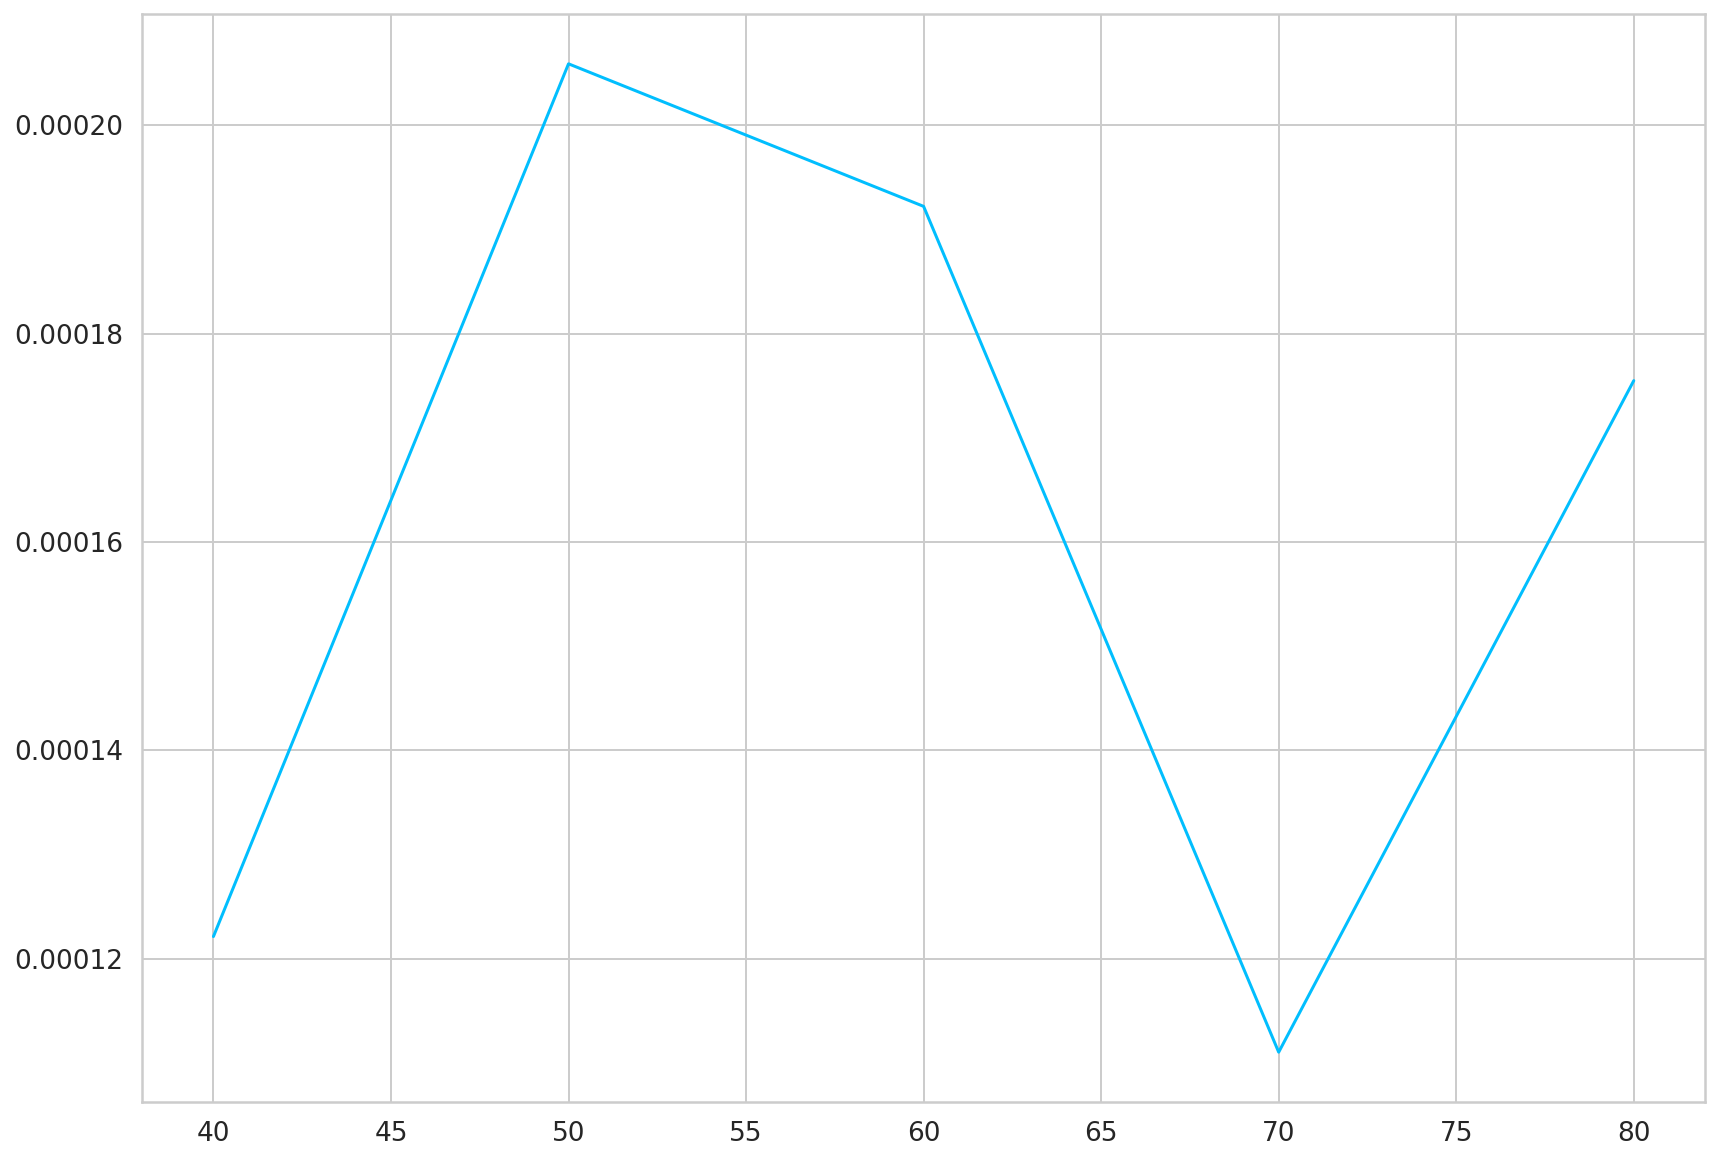

In [22]:

plt.plot(epochs_array, test_score)

In [23]:
lookback_array = [3,4,5,6,7,8]
test_accuracy = []
for look in lookback_array:
    trainX, trainY = create_dataset_global(train, look)
    testX, testY = create_dataset_global(test, look)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)
    test_accuracy.append(model.evaluate(testX, testY, batch_size = 1))

Epoch 1/10
 - 15s - loss: 3.0347e-04
Epoch 2/10
 - 15s - loss: 6.0296e-05
Epoch 3/10
 - 15s - loss: 3.7524e-06
Epoch 4/10
 - 14s - loss: 4.2166e-06
Epoch 5/10
 - 15s - loss: 4.5419e-06
Epoch 6/10
 - 15s - loss: 3.4752e-06
Epoch 7/10
 - 15s - loss: 4.3902e-06
Epoch 8/10
 - 14s - loss: 3.8707e-06
Epoch 9/10
 - 15s - loss: 4.0708e-06
Epoch 10/10
 - 15s - loss: 3.5285e-06
420/420 [==============================] - 0s 1ms/step
Epoch 1/10
 - 16s - loss: 4.5367e-04
Epoch 2/10
 - 15s - loss: 1.4420e-04
Epoch 3/10
 - 15s - loss: 1.1305e-05
Epoch 4/10
 - 15s - loss: 6.2034e-06
Epoch 5/10
 - 15s - loss: 6.1538e-06
Epoch 6/10
 - 15s - loss: 5.1846e-06
Epoch 7/10
 - 15s - loss: 5.7434e-06
Epoch 8/10
 - 15s - loss: 4.6501e-06
Epoch 9/10
 - 14s - loss: 5.0717e-06
Epoch 10/10
 - 14s - loss: 4.6479e-06
350/350 [==============================] - 0s 1ms/step
Epoch 1/10
 - 15s - loss: 3.6437e-04
Epoch 2/10
 - 15s - loss: 6.2165e-05
Epoch 3/10
 - 14s - loss: 6.6073e-06
Epoch 4/10
 - 14s - loss: 7.2970e-06


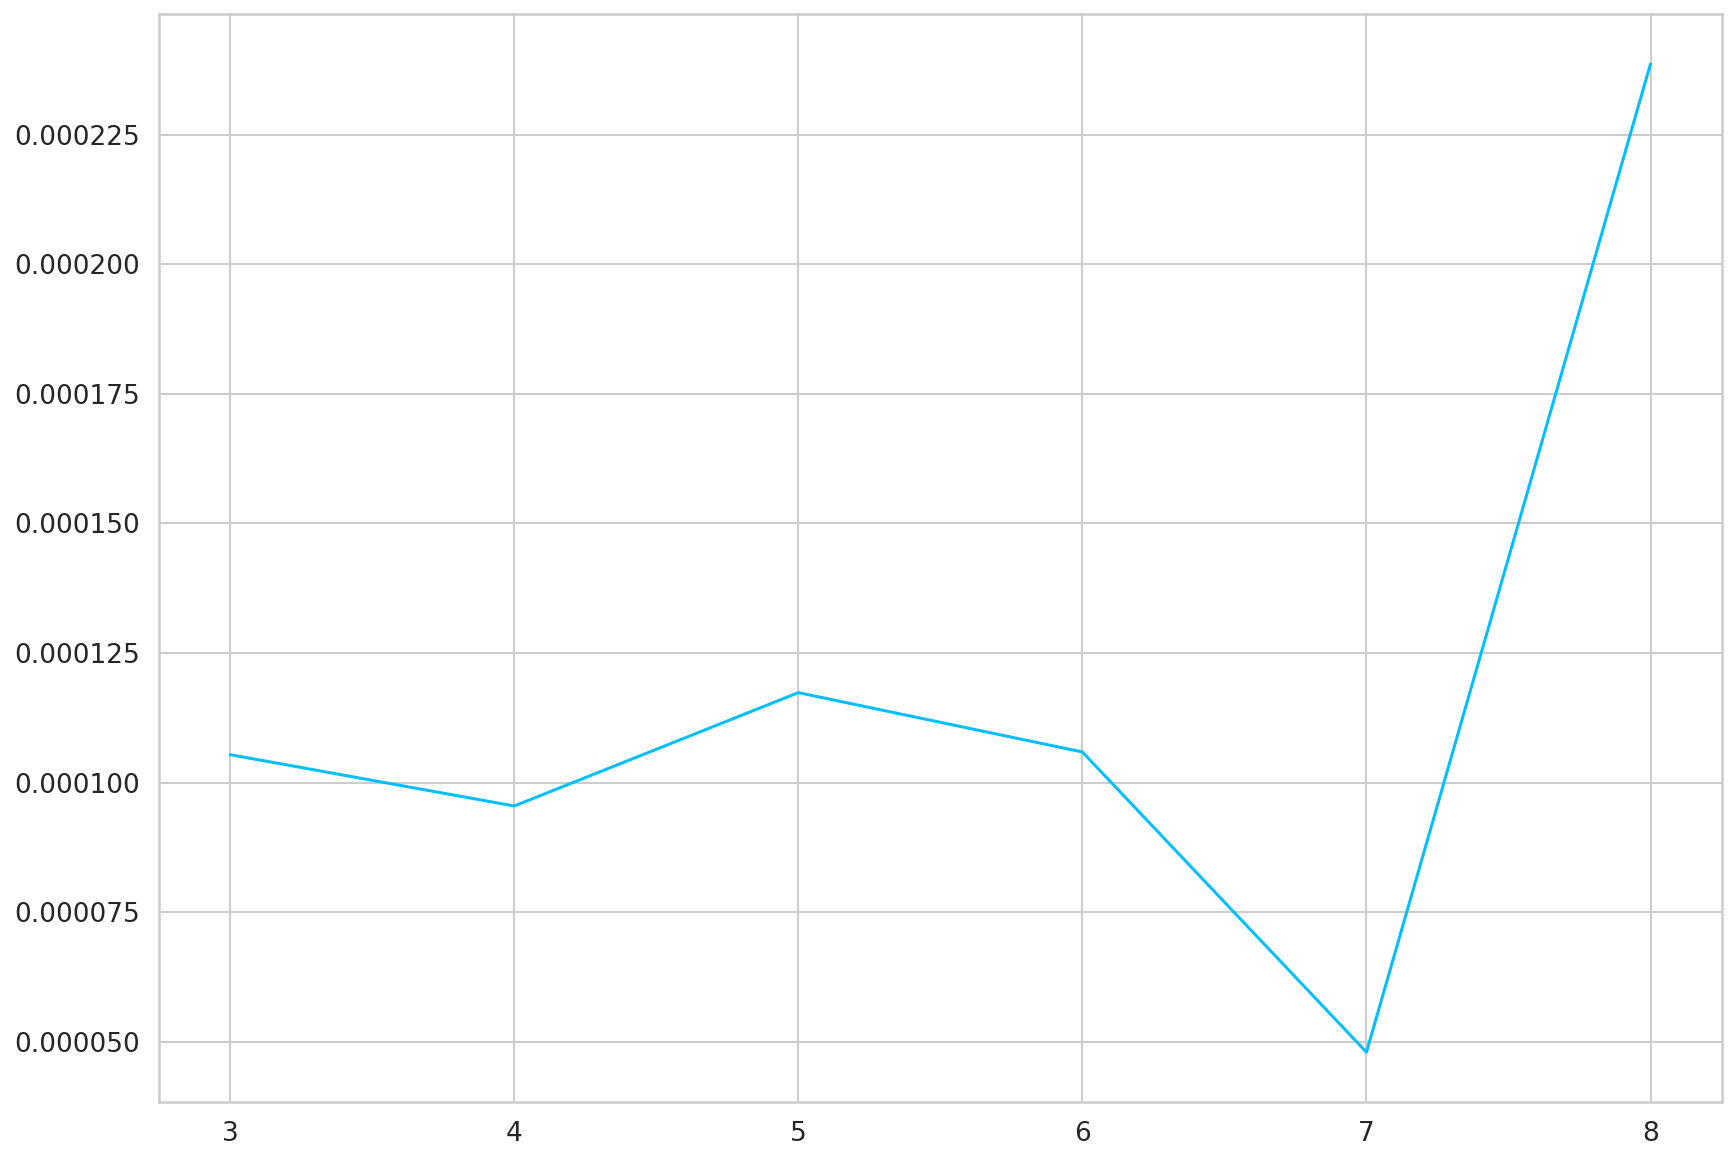

In [24]:
plt.plot(lookback_array,test_accuracy)

## test model with single country

In [0]:
def testModelSingleCountry(countryName, model):
    train = global_dataset_scale[countryMap[countryName],:-test_data_size]
    test = global_dataset_scale[countryMap[countryName],-test_data_size-look_back:]
    train = np.reshape(train, (len(train),1))
    test = np.reshape(test, (len(test),1))
    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY= create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler_global.inverse_transform(trainPredict)
    trainY = scaler_global.inverse_transform([trainY])
    testPredict = scaler_global.inverse_transform(testPredict)
    testY = scaler_global.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    return trainScore, testScore, trainPredict, testPredict

In [0]:
def plot(countryName,trainPredict,testPredict):
    # # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    length = len(scaler_global.inverse_transform([global_dataset_scale[countryMap[countryName]]])[0])
    
    testPredictPlot[len(trainPredict)+(look_back)+1:length-1, :] = testPredict
    # plot baseline and predictions
    plt.plot(scaler_global.inverse_transform([global_dataset_scale[countryMap[countryName]]])[0]*274)
    plt.plot(trainPredictPlot*274)
    plt.plot(testPredictPlot*274)
    plt.show()

In [0]:
trainScore, testScore, trainPredict, testPredict = testModelSingleCountry('US', model)
# calculate root mean squared error
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))
plot('US', trainPredict,testPredict)

Train Score: 2526.92 RMSE
Test Score: 47256.27 RMSE


ValueError: could not broadcast input array from shape (70,1) into shape (65,1)

In [0]:
trainScore, testScore, trainPredict, testPredict = testModelSingleCountry('Turkey', model)
# calculate root mean squared error
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))
plot('Turkey', trainPredict,testPredict)

Train Score: 133.36 RMSE
Test Score: 458.21 RMSE


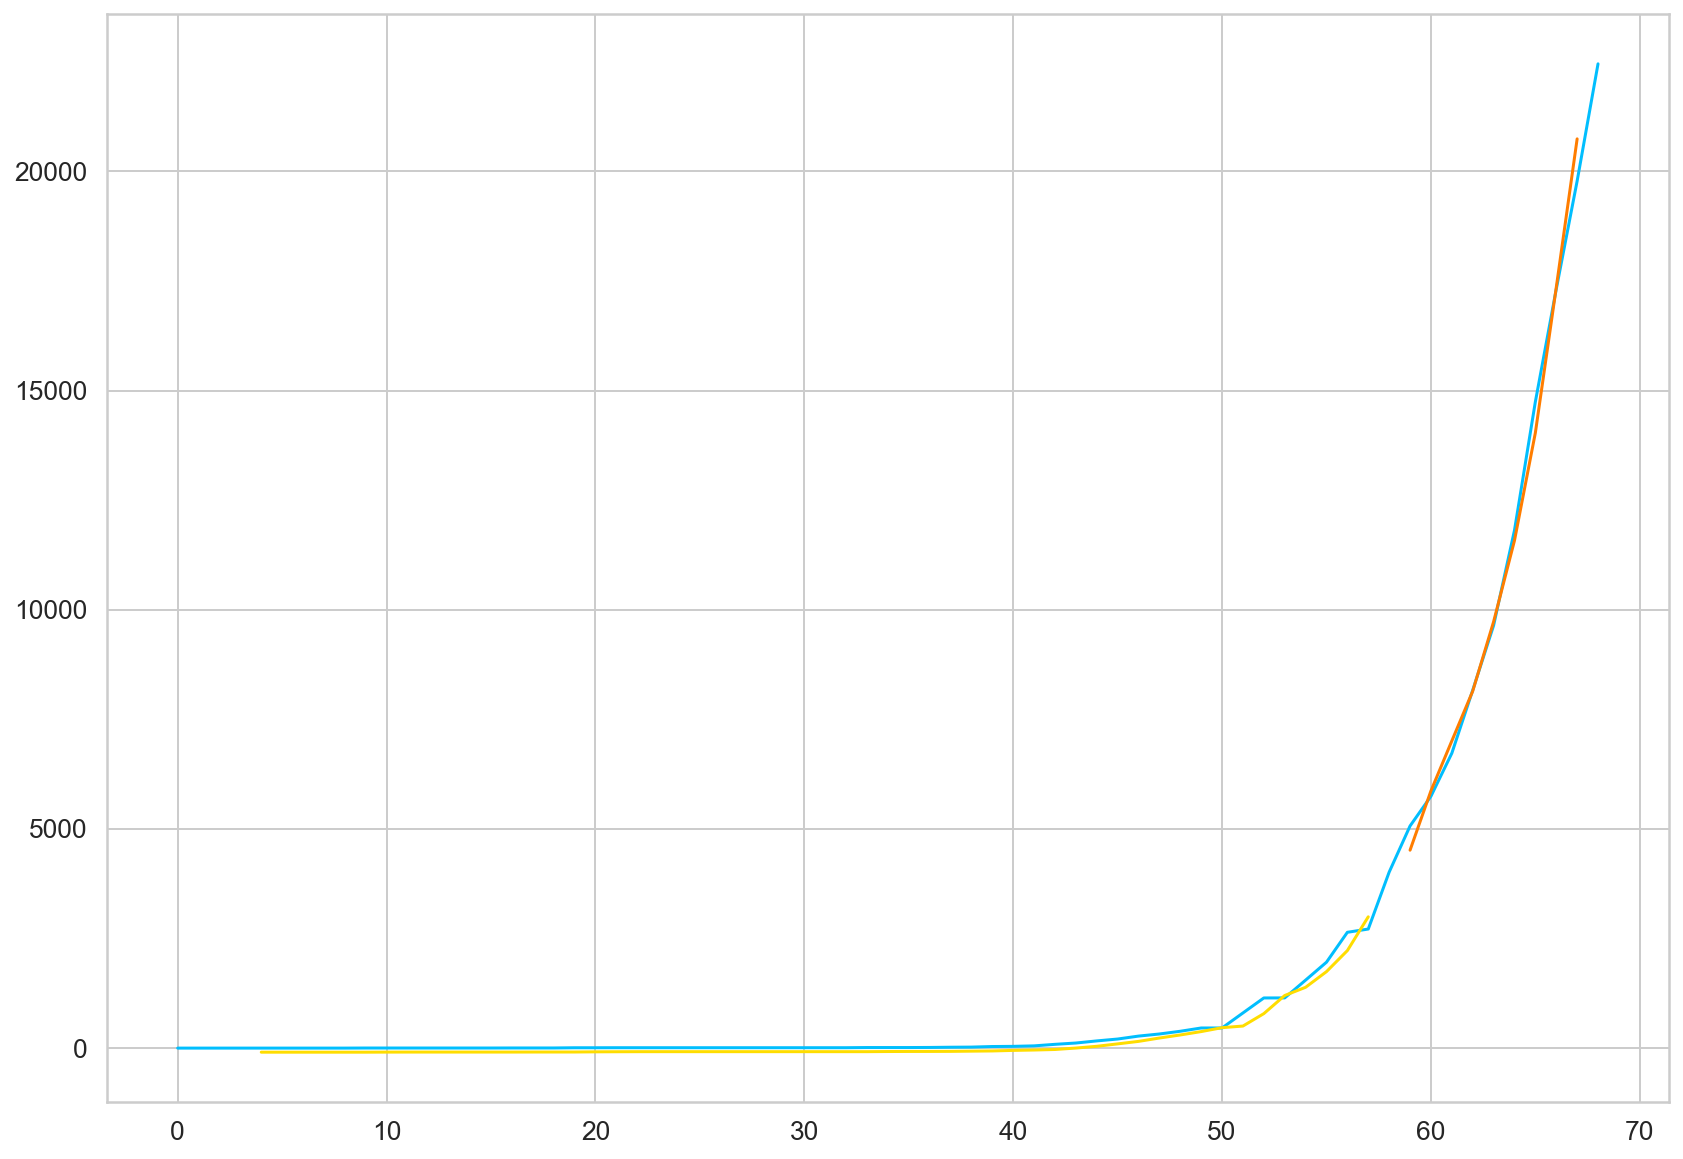

In [0]:
trainScore, testScore, trainPredict, testPredict = testModelSingleCountry('United Kingdom', model)
# calculate root mean squared error
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))
plot('United Kingdom', trainPredict,testPredict)